In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import tensorflow as tf
import pickle as pkl
from tf_model import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import evidential_deep_learning as edl
import matplotlib.pyplot as plt
from filters import *

2021-08-12 18:40:08.579956: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
input_conf = 'confc'

In [3]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = input_data.reshape(input_data.shape[0],input_data.shape[-1],input_data.shape[1])
raw_data = raw_data.reshape(raw_data.shape[0],raw_data.shape[-1],raw_data.shape[1])
annotation = pd.read_pickle('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]


2021-08-12 18:41:07.661527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-12 18:41:07.725719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 18:41:07.726517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2021-08-12 18:41:07.726533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-12 18:41:07.728005: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-12 18:41:07.728033: I tensorflow/stream_executor/platform/

In [4]:
if input_conf == 'confc':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data))
    train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data))
    test_dataset = test_dataset.batch(128)

if input_conf == 'confd':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
    train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
    test_dataset = test_dataset.batch(128)
    
if input_conf == 'confb':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , x_train_ref_rr))
    train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , x_test_ref_rr))
    test_dataset = test_dataset.batch(128)

if input_conf == 'confe':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
    train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
    test_dataset = test_dataset.batch(128)

if input_conf == 'confa':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , x_train_ref_rr))
    train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , x_test_ref_rr))
    test_dataset = test_dataset.batch(128)

if input_conf == 'conff':
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data, x_train_ref_rr))
    train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data, x_test_ref_rr))
    test_dataset = test_dataset.batch(128)
    


In [ ]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confc/best_modellr_0.0001__coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(y_batch_test,output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confd/best_model_lr_0.0001__coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
            
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confb/best_model_lr_0.0001__coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confe/best_model_lr_0.0001__coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confa/best_model_lr_0.0001__coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/conff/best_model_lr_0.0001__coeff_0.01.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)   

In [5]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-300,300])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-300 , 300])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [6]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.9,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [ ]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confb':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    

In [ ]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
        
    

In [ ]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))



# WITH EVIDENTIAL

In [7]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    coeff_val = 1e-3
    #loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/confc/best_modellr_0.0001__coeff_0.001.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
        output = model(x_batch_test)
        test_loss = edl.losses.EvidentialRegression(y_batch_test,output, coeff = coeff_val)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#------------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    coeff_val = 1e-4
    #loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/confe/best_model___coeff_0.0001.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
        output = model(x_batch_test_raw)
        test_loss = edl.losses.EvidentialRegression(y_batch_test,output, coeff = coeff_val)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    coeff_val = 0.01
    #loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/confb/best_model___coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
        output = model(x_batch_test)
        test_loss = edl.losses.EvidentialRegression(x_batch_test_ref_rr , output , coeff = coeff_val)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)

#--------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    #loss_fn = Huber()
    coeff_val = 0.01
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/confa/best_model___coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
        output = model(x_batch_test_raw)
        test_loss = edl.losses.EvidentialRegression(x_batch_test_ref_rr , output, coeff = coeff_val)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)  
        
#------------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    #loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    coeff_val = 0.05
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/conff/best_model___coeff_0.05.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = edl.losses.EvidentialRegression(y_batch_test  , test_output , coeff = coeff_val)
        test_loss_rr = edl.losses.EvidentialRegression(x_batch_test_ref_rr , test_out_rr , coeff = coeff_val)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss) 
#-------------------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    #loss_fn = Huber()
    model(tf.ones((128,128,3)))
    coeff_val = 0.01
    model.load_weights('/media/acrophase/Sentinel_1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODEL_WITH_EVI/confd/best_model___coeff_0.01.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = edl.losses.EvidentialRegression(y_batch_test  , test_output, coeff = coeff_val)
        test_loss_rr = edl.losses.EvidentialRegression(x_batch_test_ref_rr , test_out_rr,coeff = coeff_val)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)

2021-08-12 18:41:52.482972: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-12 18:41:52.819066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-12 18:41:53.244971: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-12 18:41:53.549081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-12 18:41:53.554441: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
output = gamma.numpy()
output = output.reshape(output.shape[0] , output.shape[1])


In [9]:
output

array([[0.48625895, 0.5175653 , 0.5690144 , ..., 0.41660854, 0.12975553,
        0.14771417],
       [0.49863586, 0.5005774 , 0.4763089 , ..., 0.31128347, 0.10876331,
        0.15183981],
       [0.55057037, 0.6180367 , 0.6359953 , ..., 0.32220426, 0.14686477,
        0.16458073],
       ...,
       [0.53857505, 0.5654067 , 0.6241206 , ..., 0.45081982, 0.10477076,
        0.1454917 ],
       [0.59066   , 0.6127566 , 0.58718765, ..., 0.4164122 , 0.12789331,
        0.14462362],
       [0.53762805, 0.56761634, 0.6203326 , ..., 0.29203972, 0.09293328,
        0.13791572]], dtype=float32)

In [13]:
if input_conf == 'confc':
    final_output_resp_sig = []
    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
    output = gamma.numpy()
    output = output.reshape(output.shape[0] , output.shape[1])
    for item in output:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    final_lamda = lamda.numpy()
    final_alpha = alpha.numpy()
    final_beta = beta.numpy()
    
    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
    #x_samps = np.arange(0,len(y_train_data[0]))
    aleatoric = final_beta/(final_alpha - 1)
    epistemic = final_beta/(final_lamda*(final_alpha - 1))
    print(epistemic)
    #print(x_samps)
    #plt.scatter(x_samps , y_train_data[0], s=10., c='#463c3c', zorder=0, label="Train")
    #plt.show()
if input_conf == 'confe':
    final_output_resp_sig = []
    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
    output = gamma.numpy()
    output = output.reshape(output.shape[0] , output.shape[1])
    for item in output:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    final_lamda = lamda.numpy()
    final_alpha = alpha.numpy()
    final_beta = beta.numpy()
    
    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
    x_samps = np.arange(0,len(y_train_data[0]))
    aleatoric = final_beta/(final_alpha - 1)
    epistemic = final_beta/(final_lamda*(final_alpha - 1))
    #print(x_samps)
    #plt.scatter(x_samps , y_train_data[0], s=10., c='#463c3c', zorder=0, label="Train")
    #plt.show()
#---------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
    final_output_rr = gamma.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
    final_lamda = lamda.numpy()
    final_alpha = alpha.numpy()
    final_beta = beta.numpy()
    
    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
    #x_samps = np.arange(0,len(y_train_data[0]))
    aleatoric = final_beta/(final_alpha - 1)
    epistemic = final_beta/(final_lamda*(final_alpha - 1))
    var = np.sqrt(epistemic)
    print(epistemic)

#------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
    final_output_rr = gamma.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
    final_lamda = lamda.numpy()
    final_alpha = alpha.numpy()
    final_beta = beta.numpy()
    
    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
    aleatoric = final_beta/(final_alpha - 1)
    epistemic = final_beta/(final_lamda*(final_alpha - 1))
    print(epistemic)
#-----------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    gamma_resp, lamda_resp, alpha_resp, beta_resp = tf.split(final_output, 4, axis=-1)
    gamma_rr, lamda_rr, alpha_rr, beta_rr = tf.split(final_output_rr, 4, axis=-1)
    final_output_resp = gamma_resp.numpy()
    final_rr = gamma_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0] , final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    
    final_lamda_resp = lamda_resp.numpy()
    final_alpha_resp = alpha_resp.numpy()
    final_beta_resp = beta_resp.numpy()
    
    final_lamda_rr = lamda_rr.numpy()
    final_alpha_rr = alpha_rr.numpy()
    final_beta_rr = beta_rr.numpy()
    
    aleatoric_resp = final_beta_resp/(final_alpha_resp - 1)
    epistemic_resp = final_beta_resp/(final_lamda_resp*(final_alpha_resp - 1))
    
    aleatoric_rr = final_beta_rr/(final_alpha_rr - 1)
    epistemic_rr = final_beta_rr/(final_lamda_rr*(final_alpha_rr - 1))
    
    print(aleatoric_rr)
#----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    gamma_resp, lamda_resp, alpha_resp, beta_resp = tf.split(final_output, 4, axis=-1)
    gamma_rr, lamda_rr, alpha_rr, beta_rr = tf.split(final_output_rr, 4, axis=-1)
    final_output_resp = gamma_resp.numpy()
    final_rr = gamma_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0] , final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    
    final_lamda_resp = lamda_resp.numpy()
    final_alpha_resp = alpha_resp.numpy()
    final_beta_resp = beta_resp.numpy()
    
    final_lamda_rr = lamda_rr.numpy()
    final_alpha_rr = alpha_rr.numpy()
    final_beta_rr = beta_rr.numpy()
    
    aleatoric_resp = final_beta_resp/(final_alpha_resp - 1)
    epistemic_resp = final_beta_resp/(final_lamda_resp*(final_alpha_resp - 1))
    
    aleatoric_rr = final_beta_rr/(final_alpha_rr - 1)
    epistemic_rr = final_beta_rr/(final_lamda_rr*(final_alpha_rr - 1))
    
    print(epistemic_rr)
    


[[6.07797527e-04 4.00171702e-04 2.03096497e-04 ... 1.56639318e-03
  1.13240667e-01 8.45903382e-02]
 [5.14962769e-04 5.01777860e-04 6.94780902e-04 ... 6.93262089e-03
  1.59888297e-01 7.91449100e-02]
 [2.58697371e-04 1.07361746e-04 8.51633667e-05 ... 5.91953844e-03
  8.57590660e-02 6.45173416e-02]
 ...
 [3.03540583e-04 2.13318723e-04 9.94484581e-05 ... 9.82400146e-04
  1.70899168e-01 8.77456963e-02]
 [1.53417364e-04 1.15178023e-04 1.60510070e-04 ... 1.57299545e-03
  1.16814077e-01 8.89863521e-02]
 [3.07358336e-04 2.07235717e-04 1.04432569e-04 ... 9.19081271e-03
  2.08020478e-01 9.92100760e-02]]


<IPython.core.display.Javascript object>


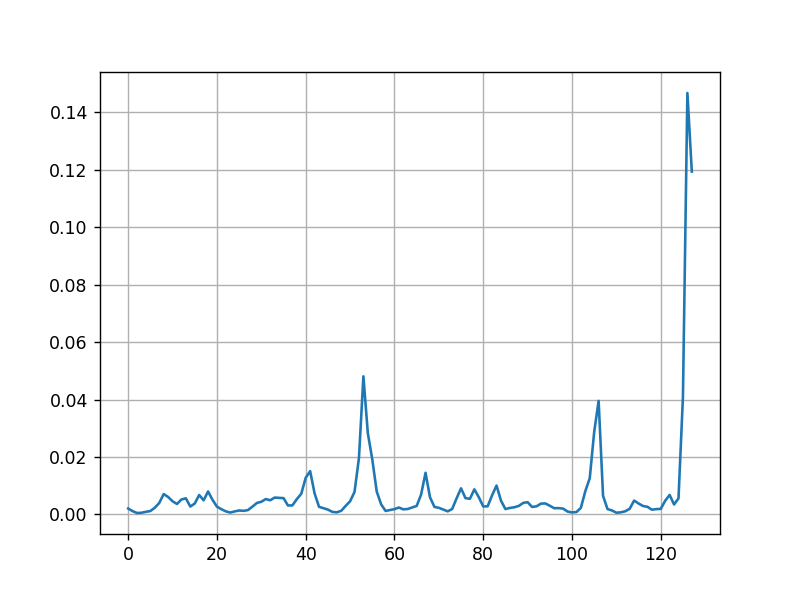